111
Using cuda
Loading and preprocessing data...
Original columns: Index(['type', 'posts'], dtype='object')
Final data columns: Index(['type', 'posts'], dtype='object')
Train size: 6072, Validation size: 1301, Test size: 1302
Initializing model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/5


Validation: 100%|██████████| 82/82 [00:47<00:00,  1.72it/s, loss=0.668]


Train Loss: 0.5494
Val Loss: 0.4733
Accuracy: 0.4650
Precision: 0.7811
Recall: 0.6562
F1 Score: 0.6934
Saved best model!
Epoch 2/5


Validation: 100%|██████████| 82/82 [00:47<00:00,  1.72it/s, loss=0.881]


Train Loss: 0.4215
Val Loss: 0.3844
Accuracy: 0.5834
Precision: 0.8114
Recall: 0.7557
F1 Score: 0.7790
Saved best model!
Epoch 3/5


Validation: 100%|██████████| 82/82 [04:34<00:00,  3.35s/it, loss=0.91] 


Train Loss: 0.3563
Val Loss: 0.3844
Accuracy: 0.5926
Precision: 0.7965
Recall: 0.7781
F1 Score: 0.7868
Epoch 4/5


Validation: 100%|██████████| 82/82 [04:36<00:00,  3.37s/it, loss=0.964]


Train Loss: 0.3179
Val Loss: 0.3753
Accuracy: 0.6111
Precision: 0.8168
Recall: 0.7770
F1 Score: 0.7942
Saved best model!
Epoch 5/5


Validation: 100%|██████████| 82/82 [04:33<00:00,  3.33s/it, loss=0.972]


Train Loss: 0.2903
Val Loss: 0.3767
Accuracy: 0.6072
Precision: 0.8165
Recall: 0.7665
F1 Score: 0.7893
Evaluating best model...


Testing: 100%|██████████| 82/82 [04:33<00:00,  3.33s/it]



Overall Results:
Accuracy: 0.5899
Precision: 0.8159
Recall: 0.7483
F1 Score: 0.7774

Results by MBTI Dimension:

E/I:
  Accuracy: 0.8556
  Precision: 0.7445
  Recall: 0.5652
  F1 Score: 0.6426

S/N:
  Accuracy: 0.8978
  Precision: 0.9287
  Recall: 0.9544
  F1 Score: 0.9414

T/F:
  Accuracy: 0.8295
  Precision: 0.8091
  Recall: 0.8253
  F1 Score: 0.8171

J/P:
  Accuracy: 0.7903
  Precision: 0.7812
  Recall: 0.6484
  F1 Score: 0.7086


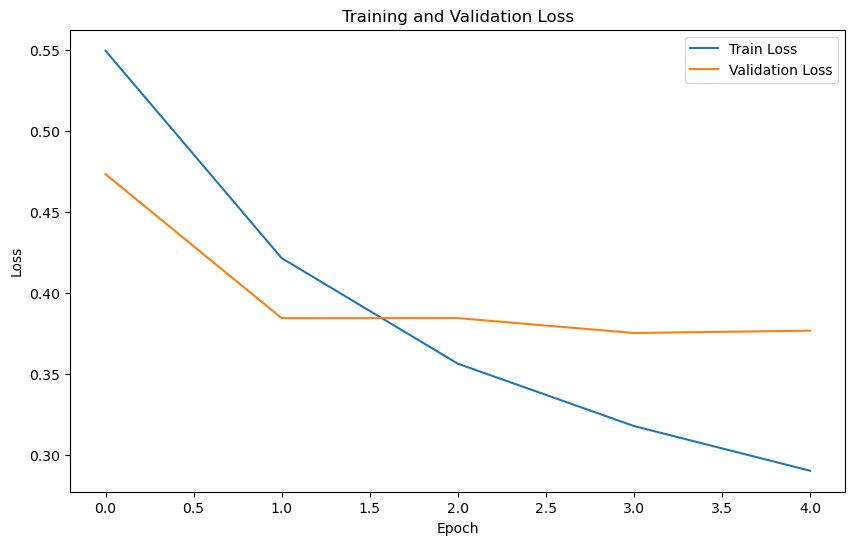

In [2]:
import os
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# Fix import issue
from transformers import RobertaModel, RobertaTokenizer, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print(111)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

# Data preprocessing
def preprocess_text(text):
    # Only perform lowercase processing, preserve original text structure
    text = text.lower()
    # Remove excessive consecutive spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove possible special marker symbols
    text = re.sub(r'\|\|\|', ' ', text)
    return text.strip()

# Split MBTI type into four binary classification problems
def split_mbti_type(mbti_type):
    ei = 1 if mbti_type[0] == 'E' else 0  # Extraversion vs Introversion
    sn = 1 if mbti_type[1] == 'N' else 0  # Intuition vs Sensing
    tf = 1 if mbti_type[2] == 'T' else 0  # Thinking vs Feeling
    jp = 1 if mbti_type[3] == 'J' else 0  # Judging vs Perceiving
    return [ei, sn, tf, jp]

# Redesigned load function to adapt to CSV format
def load_data(file_path):
    # Read data and fix CSV format issues
    data = pd.read_csv(file_path)
    print(f"Original columns: {data.columns}")
    
    # Check data format, seems like only one column, need to split
    if len(data.columns) == 1:
        # Try to split
        column_name = data.columns[0]
        print(f"Splitting column: {column_name}")
        
        # Split into two columns (first comma position)
        if "," in column_name:
            # Fix column name
            data.columns = ['combined']
            # Check first few rows
            print(data['combined'].head())
            
            # Analyze first row to determine format
            first_row = data['combined'].iloc[0]
            print(f"First row: {first_row}")
            
            # Try regex to extract MBTI type and posts
            data_list = []
            for row in data['combined']:
                match = re.match(r'(\w+),"(.*)"', row)
                if match:
                    mbti_type = match.group(1)
                    posts = match.group(2)
                    data_list.append({
                        'type': mbti_type,
                        'posts': posts
                    })
            
            # Create new DataFrame
            if data_list:
                data = pd.DataFrame(data_list)
                print(f"Successfully extracted data, new columns: {data.columns}")
                print(f"Data shape: {data.shape}")
            else:
                # Try another splitting method
                print("Trying another splitting method...")
                parts = data['combined'].str.split(',', n=1)
                data['type'] = parts.str[0]
                data['posts'] = parts.str[1:].str.join(',')
                # Clean quotes
                data['type'] = data['type'].str.strip('"')
                data['posts'] = data['posts'].str.strip().str.strip('"')
    
    # At this point, should have correct 'type' and 'posts' columns
    if 'type' not in data.columns or 'posts' not in data.columns:
        raise ValueError("Couldn't properly extract 'type' and 'posts' from the data file!")
    
    print(f"Final data columns: {data.columns}")
    
    # Convert string format, clean quotes
    data['posts'] = data['posts'].str.replace("'", "")
    
    # Process text
    data['processed_posts'] = data['posts'].apply(preprocess_text)
    
    # Split MBTI type
    mbti_binary = data['type'].apply(split_mbti_type)
    data['EI'] = [x[0] for x in mbti_binary]
    data['SN'] = [x[1] for x in mbti_binary]
    data['TF'] = [x[2] for x in mbti_binary]
    data['JP'] = [x[3] for x in mbti_binary]
    
    return data

# Custom dataset
class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        
        # Truncate overly long text, keep last max_length tokens
        if len(text) > self.max_length * 4:  # Rough estimate, one token ≈ 4 characters
            text = text[-self.max_length * 4:]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# RCNN-RoBERTa model
class RCNNRoBERTa(nn.Module):
    def __init__(self, num_classes=4):
        super(RCNNRoBERTa, self).__init__()
        
        # Load pretrained RoBERTa model
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        
        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size=768,  # RoBERTa hidden size
            hidden_size=128,
            bidirectional=True,
            batch_first=True,
            dropout=0.1
        )
        
        # Fully connected layer (simulating convolution operation)
        self.fc = nn.Linear(768 + 256, 100)  # 768(RoBERTa) + 256(BiLSTM)
        
        # Output layer - 4 binary classification heads
        self.classifier = nn.Linear(100, num_classes)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, input_ids, attention_mask):
        # RoBERTa encoding
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        roberta_hidden = roberta_output.last_hidden_state
        
        # LSTM processing
        lstm_output, _ = self.lstm(roberta_hidden)
        
        # Concatenate RoBERTa and LSTM outputs
        concat = torch.cat((roberta_hidden, lstm_output), 2)
        
        # Max pooling
        pooled = torch.max(concat, dim=1)[0]
        
        # Fully connected layer
        fc_output = F.relu(self.fc(self.dropout(pooled)))
        
        # Classification layer
        logits = self.classifier(fc_output)
        
        return logits
    
    # Feature extraction for visualization
    def get_features(self, batch):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        with torch.no_grad():
            roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
            roberta_hidden = roberta_output.last_hidden_state
            
            lstm_output, _ = self.lstm(roberta_hidden)
            concat = torch.cat((roberta_hidden, lstm_output), 2)
            pooled = torch.max(concat, dim=1)[0]
            
            # Return features before fully connected layer
            return self.fc(self.dropout(pooled))

# Fixed learning rate scheduler function
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Create linear learning rate scheduler with warmup
    """
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

    return get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc="Training")
        
        for batch in train_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            train_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc="Validation")
            
            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(input_ids, attention_mask)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Convert to binary predictions
                preds = torch.sigmoid(outputs) > 0.5
                
                all_preds.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                
                val_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Calculate evaluation metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_rcnn_roberta_model.pth')
            print("Saved best model!")
    
    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_progress_bar = tqdm(test_dataloader, desc="Testing")
        
        for batch in test_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            
            # Convert to binary predictions
            preds = torch.sigmoid(outputs) > 0.5
            
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Calculate metrics for each dimension
    dim_names = ['E/I', 'S/N', 'T/F', 'J/P']
    dim_metrics = []
    
    for i in range(4):
        dim_acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        dim_prec = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_rec = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        
        dim_metrics.append({
            'dimension': dim_names[i],
            'accuracy': dim_acc,
            'precision': dim_prec,
            'recall': dim_rec,
            'f1': dim_f1
        })
    
    results = {
        'overall': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'dimensions': dim_metrics
    }
    
    return results

# Main function
def main():
    # 1. Data loading and preprocessing
    print("Loading and preprocessing data...")
    file_path = 'C:\\Users\\Ada39\\Desktop\\ENEG8535\\group_project\\MBTI\\mbti_1.csv'  # Replace with actual data file path
    data = load_data(file_path)
    
    # 2. Split dataset
    X = data['processed_posts'].values
    y = np.array(list(zip(data['EI'], data['SN'], data['TF'], data['JP'])))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['type'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    # 3. Data preparation
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    BATCH_SIZE = 16
    MAX_LENGTH = 512
    
    train_dataset = MBTIDataset(X_train, y_train, tokenizer, max_length=MAX_LENGTH)
    val_dataset = MBTIDataset(X_val, y_val, tokenizer, max_length=MAX_LENGTH)
    test_dataset = MBTIDataset(X_test, y_test, tokenizer, max_length=MAX_LENGTH)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # 4. Model initialization
    print("Initializing model...")
    model = RCNNRoBERTa(num_classes=4)
    model.to(device)
    
    # 5. Training setup
    EPOCHS = 5  # Reduce epochs to speed up training
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 1e-5
    ADAM_EPSILON = 1e-6
    
    # Total training steps
    total_steps = len(train_dataloader) * EPOCHS
    
    # Optimizer - import AdamW from torch.optim
    optimizer = AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        eps=ADAM_EPSILON,
        weight_decay=WEIGHT_DECAY
    )
    
    # Learning rate scheduler - use fixed function
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # 6. Train model
    print("Training model...")
    train_losses, val_losses = train_model(
        model, 
        train_dataloader, 
        val_dataloader, 
        optimizer, 
        scheduler, 
        criterion, 
        EPOCHS
    )
    
    # 7. Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_loss.png')
    
    # 8. Load best model and evaluate
    print("Evaluating best model...")
    model.load_state_dict(torch.load('best_rcnn_roberta_model.pth'))
    results = evaluate_model(model, test_dataloader)
    
    # 9. Output results
    print("\nOverall Results:")
    print(f"Accuracy: {results['overall']['accuracy']:.4f}")
    print(f"Precision: {results['overall']['precision']:.4f}")
    print(f"Recall: {results['overall']['recall']:.4f}")
    print(f"F1 Score: {results['overall']['f1']:.4f}")
    
    print("\nResults by MBTI Dimension:")
    for dim in results['dimensions']:
        print(f"\n{dim['dimension']}:")
        print(f"  Accuracy: {dim['accuracy']:.4f}")
        print(f"  Precision: {dim['precision']:.4f}")
        print(f"  Recall: {dim['recall']:.4f}")
        print(f"  F1 Score: {dim['f1']:.4f}")

if __name__ == "__main__":
    main()